# LPC Testing

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps
import soundfile as sf
from IPython.display import Audio
from modified_psola import modified_psola
from detect_pitch import get_fundamental_frequency

In [2]:
def LPC_process(x, fs, order, window_time=None):
    """
    Gets LPC error coefficients for a given signal.
    """
    # Windowed LPC
    if window_time != None:
        # Window len in samples
        wlen = int(np.floor(window_time * 0.001 * fs))
        print(wlen)
        coefs = []
        error = []
        for w in range(len(x)//wlen):
            _c = librosa.lpc(x[(w*wlen):(w+1)*wlen], order=order)
            coefs.append(_c)
            error.append(sps.lfilter( _c, [1], x[(w*wlen):(w+1)*wlen])) # El filtro del error es all pole
            
    # Non-windowed LPC
    else:
        coefs = librosa.lpc(x, order=order)
        error = sps.lfilter(coefs, [1], x) # El filtro del error es all pole

    return np.array(coefs), np.array(error)

def LPC_rebuild(error_signal, coefs):
    """
    Rebuilds signal from LPC error filter coefficients, and error signal.
    """
    return sps.lfilter([1], coefs, error_signal)


# Originally PSOLA2
def psola(sample, peaks, scale):
    new_signal = np.zeros(int(len(sample)*scale)+10)
    overlap = 0.5

    for x in range(len(peaks)-1):
        period = peaks[x+1] - peaks[x]
        new_period = int(period * scale)
        z = int(peaks[x] * scale)

        hwindow = np.hamming(int(period + overlap*period*2))
        i = 0
        u = -int(period*overlap)
        for y in range(peaks[x]-int(period*overlap), peaks[x]):
            if z+u > 0 and z+u < len(new_signal):
                new_signal[z+u] += sample[y] * hwindow[i]
                i += 1
                u += 1

        u = 0
        for y in range(peaks[x], peaks[x]+period):
            if z+u > 0 and z+u < len(new_signal):
                new_signal[z+u] += sample[y] * hwindow[i]
                i += 1
                u += 1

        #overlap
        u = int(peaks[x]+period)
        for y in range(peaks[x]+period, peaks[x]+int(period*overlap)):
            if z+u > 0 and z+u < len(new_signal):
                new_signal[z+u] += sample[y] * hwindow[i]
                i += 1
                u += 1
    return new_signal


def get_periods(sample):
    freqs = np.fft.fft(sample)

    freqs[20000:len(freqs)] = 0

    y = np.fft.ifft(freqs).real

    peaks, properties = sps.find_peaks(y)

    return peaks

### Loading sample files

In [3]:
# Importing sample songs
song_filename = 'starwars.wav'
speech_filename = 'female_scale.wav'

song_samples, song_fs =librosa.load('./samples/' + song_filename)
speech_samples, speech_fs = librosa.load('./samples/' + speech_filename)

## LPC test for speech

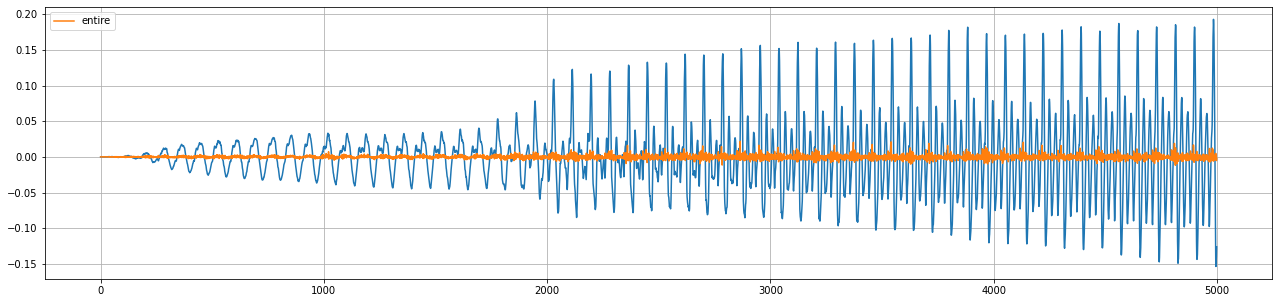

In [4]:
# Using order 12 filter to modelate voice production
lpc_speech_order = 12

# Getting LPC error filter coefficients
speech_coefs, speech_error = LPC_process(speech_samples, speech_fs, lpc_speech_order)

# Print error
plt.figure(figsize=(22,5))
plt.plot(speech_samples[2*speech_fs:2*speech_fs+5000])
plt.plot(speech_error.flatten()[2*speech_fs:2*speech_fs+5000], label='entire')
#plt.plot(_speech_error.flatten(), label='entire')
plt.grid(which='both', axis='both')
plt.legend()
plt.show()

In [5]:
# Rebuild signal using LPC filter
rebuilt_speech = LPC_rebuild(speech_error, speech_coefs)

# Save signal
sf.write(f'rebuilt_speech_LPC_order_{lpc_speech_order}.wav', rebuilt_speech, speech_fs)

# Play signal
Audio(f'rebuilt_speech_LPC_order_{lpc_speech_order}.wav')

### Plain PSOLA

In [6]:
# Time stretching factor
time_factor = 0.85

# PSOLA Algorithm
speech_psola = psola(speech_samples, get_periods(speech_samples), time_factor)

# Save signal
sf.write(f'speech_psola_x{time_factor}.wav', speech_psola, speech_fs)

# Play audio
Audio(f'speech_psola_x{time_factor}.wav')

### PSOLA using LPC error to detect peaks

In [7]:
# PSOLA Algorithm with LPC error peak detection
speech_psola_LPC_peaks = psola(speech_samples, get_periods(speech_error), time_factor)

# Save signal
sf.write(f'speech_psola_LPC_peak_x{time_factor}.wav', speech_psola_LPC_peaks, speech_fs)

# Play audio
Audio(f'speech_psola_LPC_peak_x{time_factor}.wav')

### PSOLA on LPC error signal

In [8]:
# PSOLA Algorithm on LPC error
speech_error_psola = psola(speech_error, get_periods(speech_error), time_factor)

# Regenerating signal from LPC error
speech_psola_rebuilt =  LPC_rebuild(speech_error_psola, speech_coefs)

# Save signal
sf.write(f'speech_psola_rebuilt_x{time_factor}.wav', speech_psola_rebuilt, speech_fs)

# Play audio
Audio(f'speech_psola_rebuilt_x{time_factor}.wav')

### PSOLA on short-time LPC error signal

In [24]:
# Short-time LPC on 20ms window
speech_coefs_st, speech_error_st = LPC_process(speech_samples, speech_fs, lpc_speech_order, 500)

frame_len = len(speech_error_st[0])

# Apply PSOLA to the joined error signal
speech_error_stretched = psola(speech_error_st.flatten(), get_periods(speech_error_st.flatten()), time_factor)

# Group
speech_error_stretched = np.array([[speech_error_stretched[i+j] for j in range(frame_len)] for i in range(len(speech_error_st))])

# Retransform and add
new_signal_st = np.array([LPC_rebuild(speech_error_stretched[i], speech_coefs_st[i]) for i in range(len(speech_error_st))]).flatten()

# Save signal
sf.write(f'speech_psola_rebuilt_x{time_factor}_st.wav', new_signal_st, speech_fs)

# Play audio
Audio(f'speech_psola_rebuilt_x{time_factor}_st.wav')

11025


# Modified PSOLA testing

In [9]:
################
ourLPC = False  #
################

T = 20*1e-3
samples = int(T * speech_fs)
L = samples//4
K = L

if ourLPC == True:
    a, e_ = LPC_process(speech_samples, speech_fs, 12)
    
else:
    a = librosa.lpc(speech_samples, order=12)
    e_ = sps.lfilter(a,[1], speech_samples) # obtenemos la senial error a traves del filtrado

f0,sample_f0 = get_fundamental_frequency(e_,K,L,speech_fs)

print("Frecuencia fundamental : ",f0," ", sample_f0)
speed = 1.1
error_audio = modified_psola(e_,sample_f0, speed)

if ourLPC == True:
    new_audio = LPC_rebuild(error_audio, a)
    
else:
    new_audio = sps.lfilter([1],a, error_audio)
    
sf.write("modified_psola_lpc.wav", new_audio, speech_fs)

Audio("modified_psola_lpc.wav")

Frecuencia fundamental :  134.9649563453489   164


# Modified PSOLA without LPC

In [10]:
T = 20*1e-3
samples = int(T * speech_fs)
L = samples//4
K = L

f0,sample_f0 = get_fundamental_frequency(speech_samples, K, L, speech_fs)

print("Frecuencia fundamental : ", f0, " ", sample_f0)
speed = 1.1
new_audio = modified_psola(speech_samples, sample_f0, speed)
    
sf.write("modified_psola.wav", new_audio, speech_fs)

Audio("modified_psola.wav")

Frecuencia fundamental :  134.744172986754   164
